In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy import sparse
import scipy.linalg as la
import scipy.sparse.linalg as spla
from LOD import *

In [2]:
# mesh parameters
H = 2**(-3)
h = 2**(-7)

Nx = int(1 / H)
Ny = Nx
refine = int(H / h)

mesh = build_triangular_mesh(Nx, Ny, refine)

coarse_nodes = mesh["coarse_nodes"]
fine_nodes   = mesh["fine_nodes"]
coarse_elems = mesh["coarse_elems"]
fine_elems   = mesh["fine_elems"]

N_H = coarse_nodes.shape[0]
N_h = fine_nodes.shape[0]

Text(0.5, 1.0, 'Visualization of `example_func` on the Unit Square')

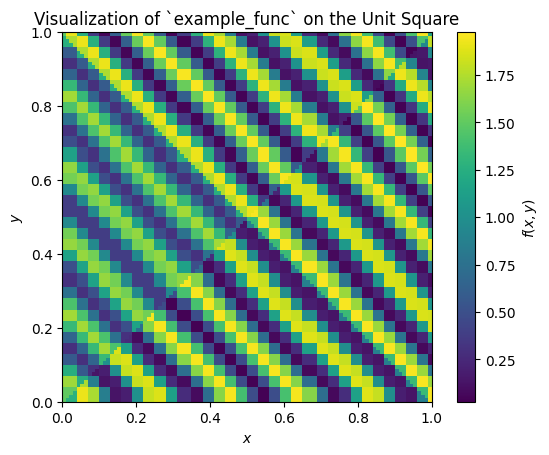

In [3]:
def example_func(x, y, eps=1/32):
    return (
        1.0
        + 1e-8
        + 0.5 * np.sin(
            np.floor(x + y)
            + np.floor(x / eps)
            + np.floor(y / eps)
        )
        + 0.5 * np.cos(
            np.floor(y - x)
            + np.floor(x / eps)
            + np.floor(y / eps)
        )
    )
    
N = 100
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

# Compute the function values
Z = example_func(X, Y)

# Visualize the function
plt.imshow(Z, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(label='$f(x, y)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Visualization of `example_func` on the Unit Square')

In [4]:
rough_coeff = lambda x,y: example_func(x,y,eps=1/32)

print("Assemble Stiffness Matrix...")
A_dc, M_dc, sigma = build_fine_element_matrices(mesh, rough_coeff, n_jobs=-1)

print("Assemble global...")
A_h, M_h = assemble_global_from_Adc_Mdc(A_dc, M_dc, sigma, N_h)

print("Assemble load vec...")
# load vector f ≡ 1
f_h = assemble_load_tri(
    fine_nodes, fine_elems, lambda x, y: 1.0
)

# interpolation and boundary matrices
print("Assemble interpolation matrix...")
P_h = build_P_triangular(mesh)
print("Assemble B_H")
B_H = build_B_H(coarse_nodes, Nx, Ny)

Assemble Stiffness Matrix...
Assemble global...
Assemble load vec...
Assemble interpolation matrix...
Assemble B_H


In [5]:
adjacency = build_coarse_adjacency_edge(coarse_elems)

In [6]:
k=3
Q_h = computeCorrections(mesh, k, adjacency, A_h, B_H, P_h, rough_coeff, n_jobs=-1)

100%|██████████| 128/128 [00:17<00:00,  7.34it/s]


In [7]:
u_h_LOD, u_H_LOD = solveLODSystem(
    A_h, f_h, P_h, Q_h, B_H
)

In [8]:
u_h_fine = solve_fine_problem(A_h, f_h, fine_nodes)

In [9]:
def relative_L2_error(u, v, M):
    diff = u - v
    num = diff @ (M @ diff)
    den = v @ (M @ v)
    return np.sqrt(num / den)

err_L2 = relative_L2_error(u_h_LOD, u_h_fine, M_h)
print("Relative L2 error:", err_L2)

Relative L2 error: 0.014014188603174646


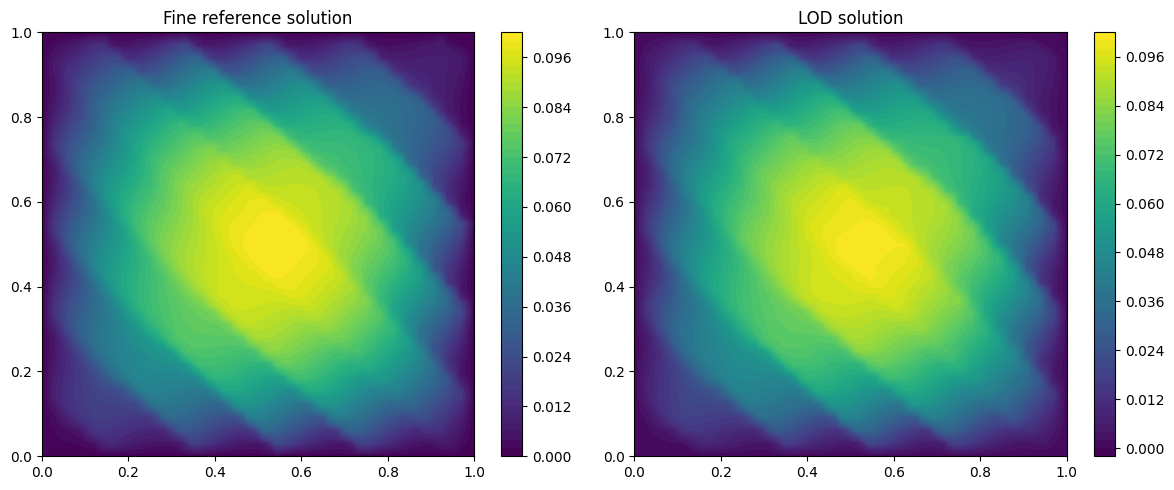

In [10]:
tri = mtri.Triangulation(
    fine_nodes[:,0],
    fine_nodes[:,1],
    fine_elems
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.tricontourf(tri, u_h_fine, levels=50)
plt.colorbar()
plt.title("Fine reference solution")

plt.subplot(1,2,2)
plt.tricontourf(tri, u_h_LOD, levels=50)
plt.colorbar()
plt.title("LOD solution")

plt.tight_layout()
plt.show()